In [48]:
import requests
import time
import datetime
import pandas as pd
import numpy as np
from pprint import pprint

In [49]:
%pylab inline
import numpy as np
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [50]:
output_notebook()

Loading BokehJS ...

In [227]:
import argparse
import ConfigParser
from oauth2client import client
from oauth2client.client import flow_from_clientsecrets

flow = flow_from_clientsecrets('client_secret.json',
                               scope=["https://www.googleapis.com/auth/youtube.readonly",
  "https://www.googleapis.com/auth/yt-analytics.readonly","https://www.googleapis.com/auth/analytics.readonly" ],
                               redirect_uri='http://localhost')
auth_uri = flow.step1_get_authorize_url()

In [228]:
print auth_uri

https://accounts.google.com/o/oauth2/auth?scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fyoutube.readonly+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fyt-analytics.readonly+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fanalytics.readonly&redirect_uri=http%3A%2F%2Flocalhost&response_type=code&client_id=970111286338-o4a1hnausq73t7pkgcph54jhr964b36r.apps.googleusercontent.com&access_type=offline


In [229]:
#code='4/ZS04Cmj7MUoVyGMhIrNYhclzOk1_8hWKoVPb5RcxH2s#'
code='4/1DgStwHUMeDXMyhaSTQ61cgVa3zdZBry_66MTHAOZTM#'

In [230]:
credentials = flow.step2_exchange(code)

In [215]:
from oauth2client.file import Storage

storage = Storage('yt_credentials_file')
storage.put(credentials)



In [216]:
credentials = storage.get()

In [231]:
import httplib2

http = httplib2.Http()
http = credentials.authorize(http)

In [232]:
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError

YOUTUBE_API_SERVICE_NAME = "youtube"
YOUTUBE_API_VERSION = "v3"
YOUTUBE_ANALYTICS_API_SERVICE_NAME = "youtubeAnalytics"
YOUTUBE_ANALYTICS_API_VERSION = "v1"

youtube = build(YOUTUBE_API_SERVICE_NAME, YOUTUBE_API_VERSION,http=http)
youtube_analytics = build(YOUTUBE_ANALYTICS_API_SERVICE_NAME,YOUTUBE_ANALYTICS_API_VERSION, http=http)


In [233]:
channel_id = 'UCSvRAIaavoY6xyR2xQZHiCg'

In [249]:
def run_analytics_report(youtube_analytics, channel_id, options,video_id):
  # Call the Analytics API to retrieve a report. For a list of available
  # reports, see:
  # https://developers.google.com/youtube/analytics/v1/channel_reports
    analytics_query_response = youtube_analytics.reports().query(
        ids="channel==%s" % channel_id,
        metrics=options.metrics(),
        dimensions=options.dimensions(),
        start_date=options.start_date(),
        end_date=options.end_date(),
        filters="video==%s"% video_id
    ##max_results=options.max_results(),
    ##sort=options.sort()
        ).execute()

 # print "Analytics Data for Channel %s" % channel_id

 # for column_header in analytics_query_response.get("columnHeaders", []):
 #   print "%-20s" % column_header["name"],
 # print

 # for row in analytics_query_response.get("rows", []):
 #   for value in row:
 #     print "%-20s" % value,
 #   print
    return analytics_query_response

In [307]:
import pandas
import numpy
import datetime
from pandas.tseries.offsets import Day, MonthEnd
from datetime import datetime, timedelta

now = datetime.now()
one_day_ago = (now - timedelta(days=1)).strftime("%Y-%m-%d")
one_week_ago = (now - timedelta(days=365)).strftime("%Y-%m-%d")

class input_builder():
    def __init__(self):
        pass
    def metrics(self):
        return "views,comments,likes,dislikes,shares"
    def dimensions(self):
        return 'month'
    def start_date(self):
        return '2012-01-01'
    def end_date(self):
        return '2016-09-01'
    def max_results(self):
        return 100
    def sort(self):
        return '-views'
    

In [309]:
options = input_builder()

In [310]:
videos_ids[0]

u'37swjwBALDI'

In [323]:
video_metrics = [run_analytics_report(youtube_analytics, channel_id, options,video_id) for video_id in videos_ids]

In [312]:
len(videos_ids)

1027

In [313]:
len(video_metrics)

1027

In [255]:
video_metrics

[{u'columnHeaders': [{u'columnType': u'DIMENSION',
    u'dataType': u'STRING',
    u'name': u'month'},
   {u'columnType': u'METRIC', u'dataType': u'INTEGER', u'name': u'views'},
   {u'columnType': u'METRIC', u'dataType': u'INTEGER', u'name': u'comments'},
   {u'columnType': u'METRIC', u'dataType': u'INTEGER', u'name': u'likes'},
   {u'columnType': u'METRIC', u'dataType': u'INTEGER', u'name': u'dislikes'},
   {u'columnType': u'METRIC', u'dataType': u'INTEGER', u'name': u'shares'}],
  u'kind': u'youtubeAnalytics#resultTable',
  u'rows': [[u'2016-07', 1.0, 0.0, 0.0, 0.0, 0.0],
   [u'2016-06', 13.0, 0.0, -1.0, 1.0, 0.0]]},
 {u'columnHeaders': [{u'columnType': u'DIMENSION',
    u'dataType': u'STRING',
    u'name': u'month'},
   {u'columnType': u'METRIC', u'dataType': u'INTEGER', u'name': u'views'},
   {u'columnType': u'METRIC', u'dataType': u'INTEGER', u'name': u'comments'},
   {u'columnType': u'METRIC', u'dataType': u'INTEGER', u'name': u'likes'},
   {u'columnType': u'METRIC', u'dataType':

In [314]:
frames = []
for n,video in enumerate(video_metrics):
    if 'rows' in video.keys():
        ##print n,video['rows']
        frame = pd.DataFrame(video['rows'])
        cols = [video['columnHeaders'][i]['name'] for i in range(len(video['columnHeaders']))]
        frame.columns = cols
        frame['id']=videos_ids[n]
        frame.index = frame['id']
        frames.append(frame)

In [258]:
frames[-1]

,month,views,comments,likes,dislikes,shares,id
id,,,,,,,
SJ8p4XOlAKM,2016-07,4.0,0.0,0.0,0.0,0.0,SJ8p4XOlAKM
SJ8p4XOlAKM,2016-06,2.0,0.0,0.0,0.0,0.0,SJ8p4XOlAKM


In [315]:
df_vid = pd.concat(frames)

In [339]:
import argparse
import ConfigParser
config = ConfigParser.ConfigParser()
config.read('.ttapis.cfg')
config.sections()
 = dict(config.items('Youtube'))

In [316]:
top_vid = df_vid.groupby('id')['views'].sum()

In [317]:
top_vid.sort(ascending=False)

/root/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  if __name__ == '__main__':


In [322]:
top_vid

id
_Ar1Bz15izU    4388.0
XyugAQ50KW8    4379.0
hmsT29187wo    3215.0
EPt48rcMMZo    2958.0
ux2SBPKlq5g    2368.0
1RkLfWimiQA    1817.0
DPRmQu7-ZbM    1654.0
NEa8g8nCOAI    1344.0
IfWhVB6vUgc    1280.0
_Nqq2IXmOGI     995.0
aT5s1RfLEfY     931.0
5a5KX3FG_bc     926.0
HCKk28jRFSo     910.0
qWvNXmJeqOI     597.0
BoSiKMpYvRU     545.0
Rd4S2Np_aoU     537.0
xbvfgyiwB6o     529.0
WBKF7cpNCZE     513.0
fRhcdl1HD-Y     482.0
NTU5r4u8X5g     476.0
gAwHee_TEUE     471.0
dr5sfJbWmS4     466.0
2R_ZldpETVE     459.0
nHI0OFGiac8     455.0
ERYxaZIrfJc     452.0
hK1lsQ-MjsU     438.0
79BBPalbHTU     433.0
8mc-hJuRFVs     428.0
OFWNDi-E_RU     423.0
nTEtUZ1hanI     405.0
                ...  
Mg5y9QDX_ps       3.0
ApHokhAr7R4       3.0
qPWWqZsduuE       3.0
HJCFZtoTBZU       3.0
FtLpbEFEXoE       3.0
E532pffuImQ       3.0
qVR5z5YbLao       3.0
crtEpz-FVSU       2.0
YpLQpiFj0no       2.0
4mqewTa3hFg       2.0
qFpSgCfz2uc       2.0
JVvKZ4Il31o       2.0
vMPVCzzgjro       2.0
u0OEswTImxI       2.0
9LB3uTe

In [330]:
for vid in top_vid.index:
    print vid

_Ar1Bz15izU
XyugAQ50KW8
hmsT29187wo
EPt48rcMMZo
ux2SBPKlq5g
1RkLfWimiQA
DPRmQu7-ZbM
NEa8g8nCOAI
IfWhVB6vUgc
_Nqq2IXmOGI
aT5s1RfLEfY
5a5KX3FG_bc
HCKk28jRFSo
qWvNXmJeqOI
BoSiKMpYvRU
Rd4S2Np_aoU
xbvfgyiwB6o
WBKF7cpNCZE
fRhcdl1HD-Y
NTU5r4u8X5g
gAwHee_TEUE
dr5sfJbWmS4
2R_ZldpETVE
nHI0OFGiac8
ERYxaZIrfJc
hK1lsQ-MjsU
79BBPalbHTU
8mc-hJuRFVs
OFWNDi-E_RU
nTEtUZ1hanI
3PsXGmcfVmQ
lOuCAoeQVyc
5O2Q8Dwi2qA
148Z92zpKNc
6pEkzylrmJQ
OyKfhZjZ3qA
i2D1-j0In_E
vjEuHp9Ne_E
wam120cmIz4
BeAXwCgQ_Og
eAHq1Tj4uBI
wRX8dB0FZAA
OBl4W77zOVU
2RPBZ1sOP1g
3JIwYXAPGYU
rdgTKIZFsQA
3yP0wHUDuco
WE7smKZ8sbA
oOBdAf-V0k0
U-oKVsJ1EK4
uduuXowdiac
w7JAX0nTgzQ
ATJrHY1EzQ8
aJn0c5zK--w
yHj5zuKDJQk
S1_EBjqT7SA
YPHTWR37lTM
ClU5aIxTD74
7ApCGnLDFkY
X_zqO6YCJO8
ouIbQxPISQ8
q501ra0JYJ4
eyTYMXRlhlY
37swjwBALDI
4C3VhQKyuRU
cvPRFm4hslM
83lh7QhU-Bk
nIh4R8vN_x4
X1kVFzL5K8c
-zaTkeATM-o
uge5N9bHluM
JDJ8Cv5o1Ls
08bfk48F8ds
g0Uy7TpjB08
3RR3gGC6Vd8
JVG9oomgV-s
K0BlqqLgBYA
H5Rb8w4GVEQ
X-dopcpOV20
lT3XwgLT9XQ
g3rT1-48Hvc
rUNUyOVAnJg
yHqio7xCVaM
2DJE

In [354]:
# Documentation
print 'https://developers.google.com/youtube/v3/docs/videos'

https://developers.google.com/youtube/v3/docs/videos


In [377]:
import json
import urllib

video_ids=top_vid.index
api_key=yt_config['api_key']
searchUrls =["https://www.googleapis.com/youtube/v3/videos?id="+video_id+"&key="+api_key+"&part=snippet" for video_id in video_ids]
responses = [urllib.urlopen(searchUrl).read() for searchUrl in searchUrls]
records = [json.loads(response) for response in responses]
record_dict = {record['items'][0]['id']:{'title':record['items'][0]['snippet']['localized']['title'], 
                                      'publishedAt':record['items'][0]['snippet']['publishedAt'],
                                      ##'tags': try: record['items'][0]['snippet']['tags'] except KeyError: []
                                         'url':'https://www.youtube.com/watch?v=%s'%record['items'][0]['id']
                                    
                                     } for record in records}

In [379]:
print record_dict['nHI0OFGiac8']['url']

https://www.youtube.com/watch?v=nHI0OFGiac8


In [372]:
records[0]['items'][0]['snippet']['tags']

[u'Trixandtrax',
 u'trix',
 u'trax',
 u'san ignacio',
 u'colegio los arcos',
 u'colegio iea',
 u'roller',
 u'skater',
 u'graffiti']

In [262]:

def Youtube_Metrics(df, metrics):
    from bokeh.palettes import Spectral11
    p = figure(x_axis_type="datetime", width=700, height=300)
    for i,metric in enumerate(metrics):
        x = pd.to_datetime(df.groupby('month')[metric].sum().index)
        y = df.groupby('month')[metric].sum().values
        p.line(x,y,color=Spectral11[i*2], legend=metric)


    p.title = "Youtube Metrics"
    p.grid.grid_line_alpha=0.3
    p.xaxis.axis_label = 'Date'
    p.yaxis.axis_label = 'Metrics'
    p.legend.location = "top_left"
    return p



In [306]:
df_vid.groupby('month')['comments'].sum().sum()

14.0

In [320]:
df_vid

,month,views,comments,likes,dislikes,shares,id
id,,,,,,,
37swjwBALDI,2015-11,7.0,0.0,0.0,0.0,0.0,37swjwBALDI
37swjwBALDI,2015-12,11.0,0.0,0.0,0.0,0.0,37swjwBALDI
37swjwBALDI,2015-10,7.0,0.0,0.0,0.0,0.0,37swjwBALDI
37swjwBALDI,2016-02,8.0,0.0,0.0,0.0,0.0,37swjwBALDI
37swjwBALDI,2016-03,9.0,0.0,0.0,0.0,0.0,37swjwBALDI
37swjwBALDI,2016-07,13.0,0.0,0.0,0.0,0.0,37swjwBALDI
37swjwBALDI,2016-06,8.0,0.0,0.0,0.0,0.0,37swjwBALDI
37swjwBALDI,2015-07,22.0,0.0,0.0,0.0,0.0,37swjwBALDI
37swjwBALDI,2016-08,3.0,0.0,0.0,0.0,0.0,37swjwBALDI


In [321]:
metrics = ['views', 'comments','shares','likes']
show(Youtube_Metrics(df_vid,metrics))

In [657]:
x = pd.to_datetime(df_vid.groupby('month')['views'].sum().index)
y = df_vid.groupby('month')['views'].sum().values

In [669]:
y

array([   542.,    476.,    135.,    158.,    232.,    120.,   1046.,
         8250.,   3315.,    871.,    668.,    886.,    617.,    692.,
          679.,    552.,    484.,    622.,   1458.,   1375.,    450.,
          302.,    276.,    255.,    409.,    799.,    554.,    590.,
         1953.,   2295.,    943.,   8453.,   2362.,   1112.,   1206.,
         1308.,   1309.,   1528.,  13242.,   3316.,   2990.,   2034.,
         2195.,   2632.,   1360.,   1290.,   1346.,   1131.,   1169.,
         1579.,   3067.])

In [707]:
df.groupby('month')['views'].sum()

month
2012-04      542
2012-05      476
2012-06      135
2012-07      158
2012-08      232
2012-09      120
2012-10     1046
2012-11     8250
2012-12     3315
2013-01      871
2013-02      668
2013-03      886
2013-04      617
2013-05      692
2013-06      679
2013-07      552
2013-08      484
2013-09      622
2013-10     1458
2013-11     1375
2013-12      450
2014-01      302
2014-02      276
2014-03      255
2014-04      409
2014-05      799
2014-06      554
2014-07      590
2014-08     1953
2014-09     2295
2014-10      943
2014-11     8453
2014-12     2362
2015-01     1112
2015-02     1206
2015-03     1308
2015-04     1309
2015-05     1528
2015-06    13242
2015-07     3316
2015-08     2990
2015-09     2034
2015-10     2195
2015-11     2632
2015-12     1360
2016-01     1290
2016-02     1346
2016-03     1131
2016-04     1169
2016-05     1579
2016-06     3067
Name: views, dtype: float64

In [709]:
p = figure(x_axis_type="datetime", width=700, height=300)
p.line(x,y,color='#FF0000', legend='views')
show(p)


TypeError: datetime.timedelta(925) is not JSON serializable

In [270]:
df_vid1 = pd.DataFrame(video_metrics[1]['rows'])
cols = [video_metrics[1]['columnHeaders'][i]['name'] for i in range(len(data['columnHeaders']))]
df_vid1.columns = cols
df_vid1['id']=videos_ids[1]
df_vid1.index = df_vid1['id']

KeyError: 'rows'

In [286]:
df_vid1

,month,views,comments,likes,dislikes,shares,id
id,,,,,,,
V-tdAK29wkg,2014-07,2,0,0,0,0,V-tdAK29wkg


In [271]:
df= df_vid.join(df_videos)

In [272]:
df['date_month']= pd.Index(df['month']).to_datetime() + pd.offsets.MonthEnd(1)

In [273]:
df['days']=(pd.to_datetime(df['date_month'])-pd.to_datetime(df['created_date']))

In [274]:
df['days']=(df['days'].values.astype('timedelta64[D]')/ np.timedelta64(1, 'D')).astype(int)

In [275]:
df['days']

-98IgFmrcBk     384
-98IgFmrcBk     415
-98IgFmrcBk     446
-JqKxvgKvcI     660
-JqKxvgKvcI     722
-PeFZq0KU28       6
-PeFZq0KU28      37
-PeFZq0KU28      68
-SkKmzlQ7V0     596
-pBisnzscQc     770
-sfXdTwEBpo    1531
-sfXdTwEBpo    1562
-sfXdTwEBpo    1593
-y70uHhV3bM     624
-zaTkeATM-o     409
-zaTkeATM-o     378
-zaTkeATM-o     440
-ziq_1iX2FA     411
-ziq_1iX2FA     380
02RtHsUMeSk     415
02RtHsUMeSk     384
04j2MrCv0gU      45
0AEi3swN6u0       6
0AEi3swN6u0      37
0AEi3swN6u0      68
0Asc1K6_Smw     420
0Asc1K6_Smw     389
0iV2q_xKNEw     408
0jyWLX3lB-k     420
0jyWLX3lB-k     389
               ... 
xxsTmeXFMOg       7
xxsTmeXFMOg      69
y4o4cv7W1q4     724
yHNl1f-g4eg     347
yHNl1f-g4eg     316
yHj5zuKDJQk     409
yHj5zuKDJQk     378
yHj5zuKDJQk     440
yHqio7xCVaM     619
yHqio7xCVaM     588
yHqio7xCVaM     650
yIhIC3933C4     184
yIhIC3933C4     215
ywAjv92-xaM     625
z4Di6bGl8lA     600
z52fwjbWjc8     594
z5wyH9kJy9w     384
zNRLhnldxgE     707
zRNLZiTGDNI     407


In [641]:
x = df['days'].values
y = df['views'].values
p = figure( width=700, height=300)
p.circle(x,y,color='#FF0000', legend='views')
show(p)

TypeError: datetime.timedelta(925) is not JSON serializable

In [278]:
import pandas
import numpy
import datetime
from pandas.tseries.offsets import Day, MonthEnd

df['EndOfMonth']=df['date_month'].values.to_period('M')

AttributeError: 'numpy.ndarray' object has no attribute 'to_period'

In [277]:
df['date_month'].dt.days_in_month

-98IgFmrcBk    30
-98IgFmrcBk    31
-98IgFmrcBk    31
-JqKxvgKvcI    30
-JqKxvgKvcI    31
-PeFZq0KU28    30
-PeFZq0KU28    31
-PeFZq0KU28    31
-SkKmzlQ7V0    30
-pBisnzscQc    30
-sfXdTwEBpo    30
-sfXdTwEBpo    31
-sfXdTwEBpo    31
-y70uHhV3bM    31
-zaTkeATM-o    31
-zaTkeATM-o    30
-zaTkeATM-o    31
-ziq_1iX2FA    31
-ziq_1iX2FA    30
02RtHsUMeSk    31
02RtHsUMeSk    30
04j2MrCv0gU    30
0AEi3swN6u0    30
0AEi3swN6u0    31
0AEi3swN6u0    31
0Asc1K6_Smw    31
0Asc1K6_Smw    30
0iV2q_xKNEw    31
0jyWLX3lB-k    31
0jyWLX3lB-k    30
               ..
xxsTmeXFMOg    30
xxsTmeXFMOg    31
y4o4cv7W1q4    31
yHNl1f-g4eg    31
yHNl1f-g4eg    30
yHj5zuKDJQk    31
yHj5zuKDJQk    30
yHj5zuKDJQk    31
yHqio7xCVaM    31
yHqio7xCVaM    30
yHqio7xCVaM    31
yIhIC3933C4    30
yIhIC3933C4    31
ywAjv92-xaM    31
z4Di6bGl8lA    30
z52fwjbWjc8    30
z5wyH9kJy9w    30
zNRLhnldxgE    30
zRNLZiTGDNI    31
zT8sM7D-MqM    30
zg7bnDX3iYA    30
ziNSuv6O9v8    31
zlFXRGAoQhc    30
zlFXRGAoQhc    31
zlFXRGAoQh

In [701]:
pd.DataFrame(df.groupby('date_month')['views'].sum()).to_csv('video_views.csv')

In [279]:
pd.concat([df_vid, df_vid1])

,month,views,comments,likes,dislikes,shares,id,0,1,2,3,4,5
id,,,,,,,,,,,,,
37swjwBALDI,2016-07,1.0,0.0,0.0,0.0,0.0,37swjwBALDI,NaN,NaN,NaN,NaN,NaN,NaN
37swjwBALDI,2016-06,13.0,0.0,-1.0,1.0,0.0,37swjwBALDI,NaN,NaN,NaN,NaN,NaN,NaN
e9MKuCc0Ux4,2016-06,1.0,0.0,0.0,0.0,0.0,e9MKuCc0Ux4,NaN,NaN,NaN,NaN,NaN,NaN
e9MKuCc0Ux4,2016-08,1.0,0.0,0.0,0.0,0.0,e9MKuCc0Ux4,NaN,NaN,NaN,NaN,NaN,NaN
ziNSuv6O9v8,2016-07,1.0,0.0,0.0,0.0,0.0,ziNSuv6O9v8,NaN,NaN,NaN,NaN,NaN,NaN
hetwExY9sP8,2016-08,1.0,0.0,0.0,0.0,0.0,hetwExY9sP8,NaN,NaN,NaN,NaN,NaN,NaN
gRSjDSlczKk,2016-06,2.0,0.0,0.0,0.0,0.0,gRSjDSlczKk,NaN,NaN,NaN,NaN,NaN,NaN
gRSjDSlczKk,2016-07,1.0,0.0,0.0,0.0,0.0,gRSjDSlczKk,NaN,NaN,NaN,NaN,NaN,NaN
G7FJSAwjPzQ,2016-07,1.0,0.0,0.0,0.0,0.0,G7FJSAwjPzQ,NaN,NaN,NaN,NaN,NaN,NaN


In [226]:
channels_response = youtube.channels().list(
  mine=True,
  part="contentDetails"
).execute()

In [228]:
pprint(channels_response)

{u'etag': u'"5g01s4-wS2b4VpScndqCYc5Y-8k/cfEjh8LX6ErT1AQzfoii_T2QbS8"',
 u'items': [{u'contentDetails': {u'relatedPlaylists': {u'favorites': u'FLSvRAIaavoY6xyR2xQZHiCg',
                                                       u'likes': u'LLSvRAIaavoY6xyR2xQZHiCg',
                                                       u'uploads': u'UUSvRAIaavoY6xyR2xQZHiCg',
                                                       u'watchHistory': u'HLSvRAIaavoY6xyR2xQZHiCg',
                                                       u'watchLater': u'WLSvRAIaavoY6xyR2xQZHiCg'}},
             u'etag': u'"5g01s4-wS2b4VpScndqCYc5Y-8k/mD3dSbS1QBTSxrjS_O02z8Vg6tk"',
             u'id': u'UCSvRAIaavoY6xyR2xQZHiCg',
             u'kind': u'youtube#channel'}],
 u'kind': u'youtube#channelListResponse',
 u'pageInfo': {u'resultsPerPage': 1, u'totalResults': 1}}


In [280]:
for channel in channels_response["items"]:
  # From the API response, extract the playlist ID that identifies the list
  # of videos uploaded to the authenticated user's channel.
    uploads_list_id = channel["contentDetails"]["relatedPlaylists"]["uploads"]

    print "Videos in list %s" % uploads_list_id

  # Retrieve the list of videos uploaded to the authenticated user's channel.
    playlistitems_list_request = youtube.playlistItems().list(
playlistId=uploads_list_id,
part="snippet",
maxResults=50
  )
    video_title_dict = {}
    video_date_dict = {}
    video_description_dict={}
    while playlistitems_list_request:
        playlistitems_list_response = playlistitems_list_request.execute()

    # Print information about each video.
        for playlist_item in playlistitems_list_response["items"]:
            title = playlist_item["snippet"]["title"]
            created = playlist_item["snippet"]["publishedAt"]
            description =  playlist_item["snippet"]["description"]
            video_id = playlist_item["snippet"]["resourceId"]["videoId"]
            video_title_dict[video_id]=title
            video_date_dict[video_id]=created
            video_description_dict[video_id]=description
            print "%s (%s)" % (title, video_id)

        playlistitems_list_request = youtube.playlistItems().list_next(
      playlistitems_list_request, playlistitems_list_response)

    print

Videos in list UUSvRAIaavoY6xyR2xQZHiCg
Apoyamos al talento juvenil venezolano #Zona #Baile #Billy (kiiv0s2zIB8)
Freestyle al estilo "Choco" (Pb6k0sDq0hQ)
Talento de sobra--- Súperheroe ---Dayana!! (HJCFZtoTBZU)
Go Diana (mmC0wdQ5Jx4)
Y en la Zona Baile --- Luis Ángel---- (A6UgI3Upn8k)
Súperheroe TRIX ---Mimo--- (ezN3rPzM3Sc)
SuperHeroes Presentación Zona Baile Colegio IEA 2016 (F97XtqUm6D4)
Eduardo Zona Trax Champagnat 2016 (h6cU2M_5xDA)
Velia Bracho Zona Baile Champagnat 2016 (oSUWI3UFXbg)
Buenos momentos enmarcados por un cuadro, esto es trix and trax en el colegio IEA (xVfrXIq6u3o)
Y así se vivió la zona baile del colegio IEA en este Trix and Trax 2016!! (A9tWuwrgm4w)
Las Chicas Del Can Talento Baile Colegio Champagnat ver2 (jjnBkgsgBsQ)
48 Talento baile Colegio IEA 2016 (DyYjjm7C4x4)
Vilan Talento Trax Colegio IEA 2016 (iOeDKtaLqkM)
Valeria Carmona Talento Trax Colegio IEA 2016 (2k6cTK1r1cA)
The Six Direction Talento Trax Colegio IEA 2016 (MXz7Yp6CLJ8)
Tamayo Talento Freestyle Col

In [281]:
len(video_date_dict)

1192

In [282]:
video_date_dict

{u'37swjwBALDI': u'2015-06-07T20:18:38.000Z',
 u'V-tdAK29wkg': u'2014-07-11T02:28:47.000Z',
 u'oTMRZWYOCl4': u'2014-08-20T15:26:53.000Z',
 u'YmLLR_IBFjk': u'2014-11-17T02:43:24.000Z',
 u'e9MKuCc0Ux4': u'2012-04-22T04:40:57.000Z',
 u'FS5VE_Rl6VI': u'2014-11-17T02:43:33.000Z',
 u'M__uPAyxzw4': u'2012-11-30T16:29:04.000Z',
 u'ziNSuv6O9v8': u'2014-11-06T16:33:06.000Z',
 u'TyrRIXsda5c': u'2014-11-11T06:38:55.000Z',
 u'GK3h1XuO-3w': u'2015-06-08T21:49:53.000Z',
 u'hetwExY9sP8': u'2014-09-04T17:00:26.000Z',
 u'nbhwxvYODRk': u'2014-09-06T14:17:54.000Z',
 u'gRSjDSlczKk': u'2016-05-01T18:52:25.000Z',
 u'G7FJSAwjPzQ': u'2014-09-06T14:24:12.000Z',
 u'M1W64PP1y_w': u'2015-06-11T15:17:50.000Z',
 u'DPRmQu7-ZbM': u'2012-11-07T14:53:15.000Z',
 u'qJKJalJgil4': u'2015-06-15T20:20:30.000Z',
 u'rUNUyOVAnJg': u'2012-11-01T21:23:30.000Z',
 u'vnb_5B2gRII': u'2014-11-11T06:38:57.000Z',
 u'UB_g8jKLkLM': u'2014-11-10T10:24:10.000Z',
 u'ERYxaZIrfJc': u'2015-06-15T20:20:30.000Z',
 u'Rd4S2Np_aoU': u'2012-10-23T21:5

In [283]:
df_video = pd.DataFrame.from_dict(video_date_dict, orient='index', dtype=datetime64)

In [284]:
df_title = pd.DataFrame.from_dict(video_title_dict, orient='index', dtype=None)

In [285]:
df_description = pd.DataFrame.from_dict(video_description_dict, orient='index', dtype=None)

In [286]:
df_title.columns = ['title']
df_video.columns = ['created_date']
df_description.columns=['description']

In [287]:
df_videos = df_title.join(df_video).join(df_description)

In [288]:
df_videos['created_date'].min()

Timestamp('2012-04-18 22:35:18')

In [291]:
df_vid_ovo = df_videos[df_videos['created_date'] > '2016-05-31']

In [295]:
df_vid_ovo

,title,created_date,description
VD2TD74rlq0,Carmen Talento Trax Colegio IEA 2016,2016-07-10 21:16:39,
bruVp9c68xk,Leopoldo Quintero Talento Trax Colegio IEA 2016,2016-07-27 23:32:11,
A6UgI3Upn8k,Y en la Zona Baile --- Luis Ángel----,2016-08-09 19:30:17,Uno de nuestros #superheroes de la zona #Baile...
MXz7Yp6CLJ8,The Six Direction Talento Trax Colegio IEA 2016,2016-07-25 05:02:25,
FtI6tCsctIo,Los Reparadores Talento Trax Colegio IEA 2016,2016-08-02 18:19:29,
knBc0J5zDLU,Sasha Talento Baile Colegio Champagnat,2016-06-24 06:40:05,
oSUWI3UFXbg,Velia Bracho Zona Baile Champagnat 2016,2016-07-28 14:04:58,
sjgQpJEdmkE,Miguel & Jesus Talento Trax Colegio Champagnat,2016-06-24 00:30:15,
MZ064F8xnBw,Isabella & Maite Talento Trax Colegio IEA 2016,2016-07-17 23:37:26,
0AEi3swN6u0,Maria Jose Talento Baile Colegio Champagnat,2016-06-23 19:54:52,


In [299]:
pd.to_datetime(df['created_date'])
#+ pd.offsets.MonthEnd(1)

-98IgFmrcBk   2015-06-11 17:16:41
-98IgFmrcBk   2015-06-11 17:16:41
-98IgFmrcBk   2015-06-11 17:16:41
-JqKxvgKvcI   2014-09-08 21:50:59
-JqKxvgKvcI   2014-09-08 21:50:59
-PeFZq0KU28   2016-06-23 19:06:56
-PeFZq0KU28   2016-06-23 19:06:56
-PeFZq0KU28   2016-06-23 19:06:56
-SkKmzlQ7V0   2014-11-11 03:39:14
-pBisnzscQc   2014-05-21 13:56:00
-sfXdTwEBpo   2012-04-20 23:18:34
-sfXdTwEBpo   2012-04-20 23:18:34
-sfXdTwEBpo   2012-04-20 23:18:34
-y70uHhV3bM   2014-11-14 02:05:39
-zaTkeATM-o   2015-06-17 12:05:42
-zaTkeATM-o   2015-06-17 12:05:42
-zaTkeATM-o   2015-06-17 12:05:42
-ziq_1iX2FA   2015-06-15 06:25:40
-ziq_1iX2FA   2015-06-15 06:25:40
02RtHsUMeSk   2015-06-11 17:01:43
02RtHsUMeSk   2015-06-11 17:01:43
04j2MrCv0gU   2016-05-15 03:17:42
0AEi3swN6u0   2016-06-23 19:54:52
0AEi3swN6u0   2016-06-23 19:54:52
0AEi3swN6u0   2016-06-23 19:54:52
0Asc1K6_Smw   2015-06-06 14:59:12
0Asc1K6_Smw   2015-06-06 14:59:12
0iV2q_xKNEw   2015-06-18 23:55:35
0jyWLX3lB-k   2015-06-06 14:08:34
0jyWLX3lB-k   

In [78]:
videos_ids = df_videos.index

In [125]:
videos_ids

Index([u'37swjwBALDI', u'M__uPAyxzw4', u'oTMRZWYOCl4', u'YmLLR_IBFjk',
       u'e9MKuCc0Ux4', u'FS5VE_Rl6VI', u'ziNSuv6O9v8', u'hetwExY9sP8',
       u'nbhwxvYODRk', u'gRSjDSlczKk',
       ...
       u'cFKhfeyBqLg', u'NCkR35FUi5A', u'DUvvIOmjEzk', u'0jyWLX3lB-k',
       u'L02BN1zq2So', u'khP_YkIlOvc', u'SJ8p4XOlAKM', u'jqV2Mk-jAIE',
       u'GN7NPJc-E10', u'9XXetw5w_-g'],
      dtype='object', length=1027)

In [80]:
pprint(data)

NameError: name 'data' is not defined

In [81]:
df = pd.DataFrame(data['rows'])

NameError: name 'data' is not defined

In [222]:
cols = [data['columnHeaders'][i]['name'] for i in range(len(data['columnHeaders']))]

In [223]:
df.columns = cols

In [224]:
df

,video,views,comments,likes,dislikes,shares
0,_Ar1Bz15izU,1146,1,9,0,2
1,1RkLfWimiQA,926,11,8,7,17
2,5a5KX3FG_bc,499,0,8,0,5
3,HCKk28jRFSo,448,0,2,1,0
4,_Nqq2IXmOGI,399,1,3,0,3
5,XyugAQ50KW8,352,0,0,0,1
6,EPt48rcMMZo,288,0,0,0,1
7,ERYxaZIrfJc,286,0,3,0,0
8,hmsT29187wo,286,0,1,0,2
9,fRhcdl1HD-Y,285,1,8,0,0


In [6]:
config = ConfigParser.ConfigParser()
config.read('.ttapis.cfg')

['.ttapis.cfg']

In [7]:
config.sections()

['Eventbrite', 'Youtube', 'Twitter']

In [8]:
yt_config = dict(config.items('Youtube'))

In [34]:
yt_config['client_secret']

'g9D42Jyvw63AbY9YN-4qPRKj'

In [10]:
CLIENT_SECRETS_FILE = ".ytapis.cfg"

In [11]:
CLIENT_SECRETS_FILE

'.ytapis.cfg'

In [21]:
os.path.dirname(os.path.abspath(".ytapis.cfg"))

'/root/home/datacourse/projects/trixandtrax'

In [168]:
from datetime import datetime, timedelta
import httplib2
import os
import sys


from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from oauth2client.tools import argparser
from oauth2client.client import flow_from_clientsecrets
from oauth2client.file import Storage
from oauth2client.tools import argparser, run_flow


# The CLIENT_SECRETS_FILE variable specifies the name of a file that contains
# the OAuth 2.0 information for this application, including its client_id and
# client_secret. You can acquire an OAuth 2.0 client ID and client secret from
# the Google Developers Console at
# https://console.developers.google.com/.
# Please ensure that you have enabled the YouTube Data and YouTube Analytics
# APIs for your project.
# For more information about using OAuth2 to access the YouTube Data API, see:
#   https://developers.google.com/youtube/v3/guides/authentication
# For more information about the client_secrets.json file format, see:
#   https://developers.google.com/api-client-library/python/guide/aaa_client_secrets
CLIENT_SECRETS_FILE = "client_secrets.json"

# These OAuth 2.0 access scopes allow for read-only access to the authenticated
# user's account for both YouTube Data API resources and YouTube Analytics Data.
YOUTUBE_SCOPES = ["https://www.googleapis.com/auth/youtube.readonly",
  "https://www.googleapis.com/auth/yt-analytics.readonly"]
YOUTUBE_API_SERVICE_NAME = "youtube"
YOUTUBE_API_VERSION = "v3"
YOUTUBE_ANALYTICS_API_SERVICE_NAME = "youtubeAnalytics"
YOUTUBE_ANALYTICS_API_VERSION = "v1"

# This variable defines a message to display if the CLIENT_SECRETS_FILE is
# missing.
MISSING_CLIENT_SECRETS_MESSAGE = """
WARNING: Please configure OAuth 2.0

To make this sample run you will need to populate the client_secrets.json file
found at:

   %s

with information from the Developers Console
https://console.developers.google.com/

For more information about the client_secrets.json file format, please visit:
https://developers.google.com/api-client-library/python/guide/aaa_client_secrets
""" % os.path.abspath(os.path.join(os.path.dirname("client_secrets.json"),
                                   CLIENT_SECRETS_FILE))


def get_authenticated_services(args):
  flow = flow_from_clientsecrets(CLIENT_SECRETS_FILE,
    scope=" ".join(YOUTUBE_SCOPES),
    message=MISSING_CLIENT_SECRETS_MESSAGE)

  storage = Storage("%s-oauth2.json" % sys.argv[0])
  credentials = storage.get()

  if credentials is None or credentials.invalid:
    credentials = run_flow(flow, storage, args)

  http = credentials.authorize(httplib2.Http())

  youtube = build(YOUTUBE_API_SERVICE_NAME, YOUTUBE_API_VERSION,
    http=http)
  youtube_analytics = build(YOUTUBE_ANALYTICS_API_SERVICE_NAME,
    YOUTUBE_ANALYTICS_API_VERSION, http=http)

  return (youtube, youtube_analytics)

def get_channel_id(youtube):
  channels_list_response = youtube.channels().list(
    mine=True,
    part="id"
  ).execute()

  return channels_list_response["items"][0]["id"]

def run_analytics_report(youtube_analytics, channel_id, options):
  # Call the Analytics API to retrieve a report. For a list of available
  # reports, see:
  # https://developers.google.com/youtube/analytics/v1/channel_reports
  analytics_query_response = youtube_analytics.reports().query(
    ids="channel==%s" % channel_id,
    metrics=options.metrics,
    dimensions=options.dimensions,
    start_date=options.start_date,
    end_date=options.end_date,
    max_results=options.max_results,
    sort=options.sort
  ).execute()

  print "Analytics Data for Channel %s" % channel_id

  for column_header in analytics_query_response.get("columnHeaders", []):
    print "%-20s" % column_header["name"],
  print

  for row in analytics_query_response.get("rows", []):
    for value in row:
      print "%-20s" % value,
    print

if __name__ == "__main__":
  now = datetime.now()
  one_day_ago = (now - timedelta(days=1)).strftime("%Y-%m-%d")
  one_week_ago = (now - timedelta(days=7)).strftime("%Y-%m-%d")

  argparser.add_argument("--metrics", help="Report metrics",
                         default="views,comments,likes,dislikes,shares")
  argparser.add_argument("--dimensions", help="Report dimensions",
    default="video")
  argparser.add_argument("--start-date", default=one_week_ago,
    help="Start date, in YYYY-MM-DD format")
  argparser.add_argument("--end-date", default=one_day_ago,
    help="End date, in YYYY-MM-DD format")
  argparser.add_argument("--max-results", help="Max results", default=10)
  argparser.add_argument("--sort", help="Sort order", default="-views")
  args = argparser.parse_args()

  (youtube, youtube_analytics) = get_authenticated_services(args)
  try:
    channel_id = get_channel_id(youtube)
    run_analytics_report(youtube_analytics, channel_id, args)
  except HttpError, e:
    print "An HTTP error %d occurred:\n%s" % (e.resp.status, e.content)
    %tb

ArgumentError: argument --metrics: conflicting option string(s): --metrics

In [169]:
"""Hello Analytics Reporting API V4."""

import argparse

from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
import httplib2
from oauth2client import client
from oauth2client import file
from oauth2client import tools

SCOPES = ['https://www.googleapis.com/auth/analytics.readonly']
DISCOVERY_URI = ('https://analyticsreporting.googleapis.com/$discovery/rest')
CLIENT_SECRETS_PATH = 'client_secret.json' # Path to client_secrets.json file.
VIEW_ID = '66160762'


def initialize_analyticsreporting():
  """Initializes the analyticsreporting service object.

  Returns:
    analytics an authorized analyticsreporting service object.
  """
  # Parse command-line arguments.
  parser = argparse.ArgumentParser(
      formatter_class=argparse.RawDescriptionHelpFormatter,
      parents=[tools.argparser])
  flags = parser.parse_args([])

  # Set up a Flow object to be used if we need to authenticate.
  flow = client.flow_from_clientsecrets(
      CLIENT_SECRETS_PATH, scope=SCOPES,
      message=tools.message_if_missing(CLIENT_SECRETS_PATH))

  # Prepare credentials, and authorize HTTP object with them.
  # If the credentials don't exist or are invalid run through the native client
  # flow. The Storage object will ensure that if successful the good
  # credentials will get written back to a file.
  storage = file.Storage('analyticsreporting.dat')
  credentials = storage.get()
  if credentials is None or credentials.invalid:
    credentials = tools.run_flow(flow, storage, flags)
  http = credentials.authorize(http=httplib2.Http())

  # Build the service object.
  analytics = build('analytics', 'v4', http=http, discoveryServiceUrl=DISCOVERY_URI)

  return analytics

def get_report(analytics):
  # Use the Analytics Service Object to query the Analytics Reporting API V4.
  return analytics.reports().batchGet(
      body={
        'reportRequests': [
        {
          'viewId': VIEW_ID,
          'dateRanges': [{'startDate': '7daysAgo', 'endDate': 'today'}],
          'metrics': [{'expression': 'ga:sessions'}]
        }]
      }
  ).execute()


def print_response(response):
  """Parses and prints the Analytics Reporting API V4 response"""

  for report in response.get('reports', []):
    columnHeader = report.get('columnHeader', {})
    dimensionHeaders = columnHeader.get('dimensions', [])
    metricHeaders = columnHeader.get('metricHeader', {}).get('metricHeaderEntries', [])
    rows = report.get('data', {}).get('rows', [])

    for row in rows:
      dimensions = row.get('dimensions', [])
      dateRangeValues = row.get('metrics', [])

      for header, dimension in zip(dimensionHeaders, dimensions):
        print header + ': ' + dimension

      for i, values in enumerate(dateRangeValues):
        print 'Date range (' + str(i) + ')'
        for metricHeader, value in zip(metricHeaders, values.get('values')):
          print metricHeader.get('name') + ': ' + value


def main():

  analytics = initialize_analyticsreporting()
  response = get_report(analytics)
  print_response(response)

if __name__ == '__main__':
  main()

KeyboardInterrupt: 

In [170]:
"""Hello Analytics Reporting API V4."""

import argparse

from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
import httplib2
from oauth2client import client
from oauth2client import file
from oauth2client import tools

SCOPES = ['https://www.googleapis.com/auth/analytics.readonly']
DISCOVERY_URI = ('https://analyticsreporting.googleapis.com/$discovery/rest')
CLIENT_SECRETS_PATH = 'client_secret.json' # Path to client_secrets.json file.
VIEW_ID = '66183503'


In [171]:
def initialize_analyticsreporting():
  """Initializes the analyticsreporting service object.

  Returns:
    analytics an authorized analyticsreporting service object.
  """
  # Parse command-line arguments.
  parser = argparse.ArgumentParser(
      formatter_class=argparse.RawDescriptionHelpFormatter,
      parents=[tools.argparser])
  flags = parser.parse_args([])

  # Set up a Flow object to be used if we need to authenticate.
  flow = client.flow_from_clientsecrets(
      CLIENT_SECRETS_PATH, scope=SCOPES,
      message=tools.message_if_missing(CLIENT_SECRETS_PATH))

  # Prepare credentials, and authorize HTTP object with them.
  # If the credentials don't exist or are invalid run through the native client
  # flow. The Storage object will ensure that if successful the good
  # credentials will get written back to a file.
  storage = file.Storage('analyticsreporting.dat')
  credentials = storage.get()
  if credentials is None or credentials.invalid:
    credentials = tools.run_flow(flow, storage, flags)
  http = credentials.authorize(http=httplib2.Http())

  # Build the service object.
  analytics = build('analytics', 'v4', http=http, discoveryServiceUrl=DISCOVERY_URI)

  return analytics

In [172]:
analytics = build('analytics', 'v4', http=http, discoveryServiceUrl=DISCOVERY_URI)

In [173]:
def get_report(analytics):
  # Use the Analytics Service Object to query the Analytics Reporting API V4.
  return analytics.reports().batchGet(
      body={
        'reportRequests': [
        {
          'viewId': VIEW_ID,
          'dateRanges': [{'startDate': '2016-06-01', 'endDate': '2016-08-16'}],
          'metrics': [{'expression': 'ga:users'},{'expression': 'ga:sessions'} ],
                    "dimensions": [
        {
          "name":"ga:yearMonth"
        }]
        }]
      }
  ).execute()

In [174]:
def print_response(response):
  """Parses and prints the Analytics Reporting API V4 response"""

  for report in response.get('reports', []):
    columnHeader = report.get('columnHeader', {})
    dimensionHeaders = columnHeader.get('dimensions', [])
    metricHeaders = columnHeader.get('metricHeader', {}).get('metricHeaderEntries', [])
    rows = report.get('data', {}).get('rows', [])

    for row in rows:
      dimensions = row.get('dimensions', [])
      dateRangeValues = row.get('metrics', [])

      for header, dimension in zip(dimensionHeaders, dimensions):
        print header + ': ' + dimension

      for i, values in enumerate(dateRangeValues):
        print 'Date range (' + str(i) + ')'
        for metricHeader, value in zip(metricHeaders, values.get('values')):
          print metricHeader.get('name') + ': ' + value

In [175]:
response = get_report(analytics)
print_response(response)

ga:yearMonth: 201606
Date range (0)
ga:users: 1686
ga:sessions: 2589
ga:yearMonth: 201607
Date range (0)
ga:users: 1158
ga:sessions: 1266
ga:yearMonth: 201608
Date range (0)
ga:users: 1731
ga:sessions: 1811


In [176]:
pprint(response)

{u'reports': [{u'columnHeader': {u'dimensions': [u'ga:yearMonth'],
                                 u'metricHeader': {u'metricHeaderEntries': [{u'name': u'ga:users',
                                                                             u'type': u'INTEGER'},
                                                                            {u'name': u'ga:sessions',
                                                                             u'type': u'INTEGER'}]}},
               u'data': {u'isDataGolden': True,
                         u'maximums': [{u'values': [u'1731', u'2589']}],
                         u'minimums': [{u'values': [u'1158', u'1266']}],
                         u'rowCount': 3,
                         u'rows': [{u'dimensions': [u'201606'],
                                    u'metrics': [{u'values': [u'1686',
                                                              u'2589']}]},
                                   {u'dimensions': [u'201607'],
                      

In [177]:
pd.DataFrame([pd.Series([response['reports'][0]['data']['rows'][month]['dimensions'] for month in response['reports'][0]['data']['rows']] ), 
             pd.Series([response['reports'][0]['data']['rows'][month]['metrics']['values'] for month in response['reports'][0]['data']['rows']])])

TypeError: list indices must be integers, not dict

In [178]:
pprint(response['reports'][0]['data']['rows'][0])

{u'dimensions': [u'201606'], u'metrics': [{u'values': [u'1686', u'2589']}]}


In [179]:
month_year =pd.Series([response['reports'][0]['data']['rows'][i]['dimensions'][0] for i in range(len( response['reports'][0]['data']['rows']))])

In [180]:
pprint(response['reports'][0]['data']['rows'][0]['dimensions'][0])

u'201606'


In [181]:
users = pd.Series([response['reports'][0]['data']['rows'][i]['metrics'][0]['values'][0] for i in range(len( response['reports'][0]['data']['rows']))])

In [182]:
sessions = pd.Series([response['reports'][0]['data']['rows'][i]['metrics'][0]['values'][1] for i in range(len( response['reports'][0]['data']['rows']))])

In [183]:
df_ga = pd.DataFrame([month_year, users,sessions]).transpose()

In [184]:
df_ga.columns=['month_year', 'users', 'sessions']

In [185]:
df_ga['month_year']=pd.to_datetime(df_ga['month_year'], format='%Y%m')

In [186]:
 df_ga['date_month']= pd.Index(df_ga['month_year']) + pd.offsets.MonthEnd(1)

In [187]:
df_ga

,month_year,users,sessions,date_month
0,2016-06-01,1686,2589,2016-06-30
1,2016-07-01,1158,1266,2016-07-31
2,2016-08-01,1731,1811,2016-08-31


In [696]:
df_ga[['date_month','users']].to_csv('page_users.csv')

In [671]:
x = df_ga['date_month']
y = df_ga['users']
y2= df_ga['sessions']

p = figure(x_axis_type="datetime", width=700, height=300)
p.line(x,y,color='#FF0000', legend='views')
show(p)


TypeError: datetime.timedelta(925) is not JSON serializable

In [679]:

y2=y2.values.astype(int)

In [677]:
y

array([ 189,  193,  112,   63,   54,   34,   59,   75,   71,   63,   30,
         32,   16,   19,   17,   13,   15,   13,   12,    8,  101, 4148,
       1037,  682, 3542, 1015,  626,  518,  675,  509, 2185, 7374, 1888,
       1360,  730, 2926, 1029,  388,  586,  382,  332,  189, 3255, 1686,
         13])

In [680]:
y2

array([  697,   696,   408,   202,   141,   119,   146,   116,   111,
          94,    46,    51,    35,    22,    24,    22,    30,    15,
          14,    12,   215,  5679,  1493,   928,  5319,  1125,   702,
         580,   720,   638,  2740, 10143,  2200,  1549,   898,  3485,
        1261,   432,   652,   444,   384,   221,  4012,  2589,    13])

In [682]:
p = figure( width=700, height=300)
p.circle(y2,y,color='#FF0000', legend='views')


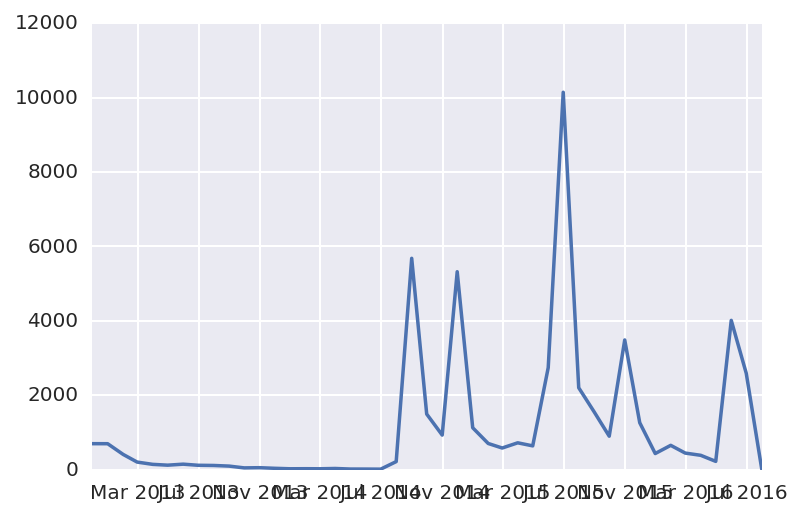

In [688]:
plot(x,y2)